**Student: Titouan Le Breton**

**Important note:** In exercise 2 question 4, a runtime error is raised on purpose. This is because the columns between the estimated and true parameters in the GMM might not be in the same order, and metrics such as MSE will be invalid unless the order matches.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd

# Exercise 1

### Question 1

To generate a random variable $Y$ taking values in $X = \{v_1, \dots, v_K\}$ with probabilities $(\pi_k)_{k=1}^K$, we first compute the partial sums $s_i = \sum_{k=1}^i \pi_k$, with $s_0 = 0$.  
We then draw $U \sim \mathcal{U}[0,1)$ and assign to $Y$ the value $v_i$ corresponding to the unique index $i$ such that $s_{i-1} \le U < s_i$.


### Question 2

In [2]:
def sample_pi(array_pi, array_v, N):
    # create the s_i
    array_pi_sum = np.cumsum(array_pi)
    array_pi_sum = np.insert(array_pi_sum, 0 ,0)

    # sample unfiormly
    array_u = np.random.rand(N)

    # find the 
    sampled_value = []
    for sample_u in array_u:
        for index_value in range(len(array_v)): # -1 beccause we added 0 at the beggining
            if array_pi_sum[index_value] <= sample_u < array_pi_sum[index_value + 1]:
                sampled_value.append(array_v[index_value])
                break
    
    return np.array(sampled_value)


In [3]:
array_pi = np.array([0.3, 0.2, 0.5])
array_v = np.array([-1, 2, 5])
N = 10

sample_pi(array_pi, array_v, N)

array([ 5,  5, -1,  5, -1,  5,  2,  2,  2, -1])

### Question 3

In [4]:
array_v = np.array([-3, -1, 0, 1, 2, 3, 4, 5, 7, 10])
array_pi = np.array([0.05, 0.10, 0.08, 0.07, 0.10, 0.15, 0.10, 0.05, 0.15, 0.15])
N = 1000

array_sample_v = sample_pi(array_pi, array_v, N)

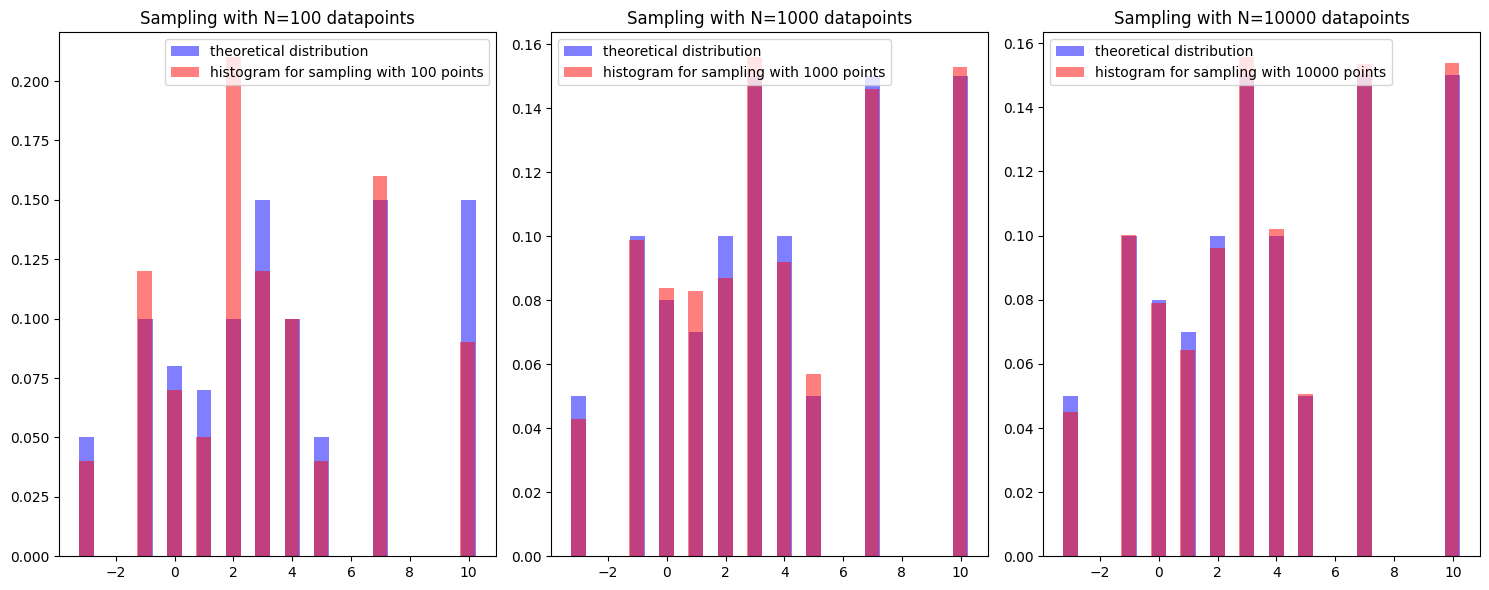

In [5]:
def plot_empirical_vs_theoretical(array_pi, array_v, N, sample_pi, ax):
    #Sample
    array_sample_v = sample_pi(array_pi, array_v, N)

    #format for plotting
    bins = np.arange(min(array_v) - 0.4, max(array_v) + 0.8, 0.8)
    counts, bins = np.histogram(array_sample_v, bins=500)
    heights = counts / counts.sum()

    ax.bar(array_v, array_pi, color="blue", alpha=0.5, label="theoretical distribution", width=0.5)
    ax.bar(bins[:-1], heights, width=0.5, color="red", alpha=0.5, label=f"histogram for sampling with {N} points")
    ax.set_title(f"Sampling with N={N} datapoints")
    ax.legend()

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for ax, N in zip(axes, [int(1e2), int(1e3), int(1e4)]):
    plot_empirical_vs_theoretical(array_pi, array_v, N, sample_pi, ax)

plt.tight_layout()
plt.show()

**Observations**: as N increases, the distribution of sampled data gets closer to the empirical distribution. This is no surprise: it is the law of large numbers.

# Exercise 2

### Question 1

For a given data point $x_i$, we have: $$ f_\theta(x_i) \;=\; \sum_{j=1}^m p_\alpha(Z_i=j)\; p_{\mu_j,\Sigma_j}(x_i \mid Z_i=j)
\;=\; \sum_{j=1}^m \alpha_j \;\mathcal N(x_i \mid \mu_j,\Sigma_j). $$

With $p_\alpha(Z_i=j)=\alpha_j$,, and:
$$
\mathcal N(x \mid \mu_j,\Sigma_j)
= \frac{1}{(2\pi)^{d/2}|\Sigma_j|^{1/2}}
\exp\!\left(-\tfrac12 (x-\mu_j)^\top \Sigma_j^{-1}(x-\mu_j)\right).
$$

For i.i.d. data $x_1,\dots,x_n$,
$$
L(x_1,\dots,x_n;\theta)
= \prod_{i=1}^n f_\theta(x_i)
= \prod_{i=1}^n \sum_{j=1}^m \alpha_j \,\mathcal N(x_i \mid \mu_j,\Sigma_j).
$$

Therefore, the parameters $theta$ are:
$$
\theta \;=\; (\alpha_1,\dots,\alpha_m,\; \mu_1,\dots,\mu_m,\; \Sigma_1,\dots,\Sigma_m)
$$

We also notice that the log-likelihood is:
$
\ell(\theta)
= \sum_{i=1}^n \log\!\left(\sum_{j=1}^m \alpha_j \,\mathcal N(x_i \mid \mu_j,\Sigma_j)\right)
$
, which is a non-concave function (sum of a log of sums) that cannot be directly maximised, so EM is required


### Question 2

In [6]:
# Defining the parameters of the distribution

K_clusters = 3

alpha_array = np.array([3/10, 2/10, 5/10])
z_array = np.array([0, 1, 2])

mu_array = np.array([
    [-2,0],
    [3,1],
    [2,-1]
])

sigma_1 = np.array([
    [0.2, 0],
    [0, 0.1]
])

sigma_2 = np.array([
    [0.5, 0.2],
    [0.2, 0.4]
])

sigma_3 = np.array([
    [0.5, -0.2],
    [-0.2, 0.7]
])

sigma_matrix = np.stack([sigma_1, sigma_2, sigma_3], axis=0)

In [7]:
N_samples = 200

def sample(alpha_array, z_array, mu_array, sigma_matrix, N_samples):
    # Sample z, the class
    z_samples_array = sample_pi(alpha_array, z_array, N_samples)

    # Sample x, the datapoint 
    X = np.ones((N_samples, mu_array.shape[1]))
    for z_i in z_array:
        z_mask = z_samples_array == z_i
        z_n = z_mask.sum()
        X[z_mask] = np.random.multivariate_normal(mean = mu_array[z_i], cov=sigma_matrix[z_i], size=z_n)
    
    # return the sampled point, but also the class that it comes from
    return X, z_samples_array

X_samples_array, z_samples_array = sample(alpha_array, z_array, mu_array, sigma_matrix, N_samples)

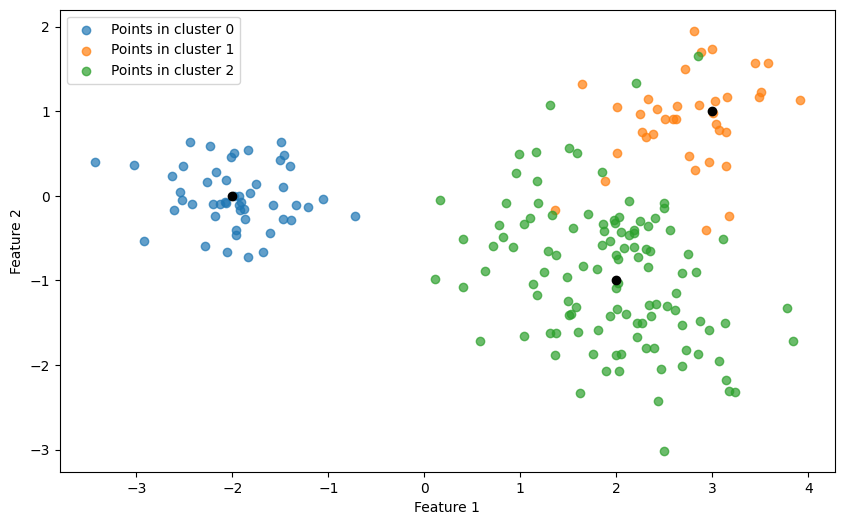

In [8]:
def plot_GMM(X_samples_array, z_samples_array, z_array, mu_array=None):
    plt.figure(figsize=(10,6))
    for z_i in z_array:
        z_mask = z_samples_array == z_i
        plt.scatter(X_samples_array[z_mask, 0], X_samples_array[z_mask, 1], label=f"Points in cluster {z_i}", alpha=0.7)
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.legend()
    if mu_array is not None:
        plt.scatter(mu_array[:,0], mu_array[:,1], color="black")
    plt.show()

plot_GMM(X_samples_array, z_samples_array, z_array, mu_array=mu_array)

### Question 3


The computational steps for implementing the EM algorithm in the context of GMM are the following:

I. E-step

We compute the responsibilities (posterior probabilities):

$$
\gamma_{ik}^{(t)} = P(z_i = k \mid x_i, \theta^{(t)}) =
\frac{\alpha_k^{(t)} \, \mathcal{N}(x_i \mid \mu_k^{(t)}, \Sigma_k^{(t)})}
{\sum_{j=1}^m \alpha_j^{(t)} \, \mathcal{N}(x_i \mid \mu_j^{(t)}, \Sigma_j^{(t)})}.
$$



II. M-step

We update the parameters using these responsibilities.

First, define:

$$
N_k^{(t)} = \sum_{i=1}^{N\_samples} \gamma_{ik}^{(t)}.
$$

Then update:

$$
\alpha_k^{(t+1)} = \frac{N_k^{(t)}}{N\_samples}, \quad
\mu_k^{(t+1)} = \frac{1}{N_k^{(t)}} \sum_{i=1}^{N\_samples} \gamma_{ik}^{(t)} x_i,
$$

$$
\Sigma_k^{(t+1)} = \frac{1}{N_k^{(t)}} \sum_{i=1}^{N\_samples} \gamma_{ik}^{(t)} (x_i - \mu_k^{(t+1)})(x_i - \mu_k^{(t+1)})^\top.
$$


We start by defining the functions for computing the parameters and estimating the variables at different steps of the EM algorithm:

In [10]:
# E-step funcitons
# -------------------------------------------------------

def compute_gamma(X_samples_array, alpha_t_array, mu_t_array, sigma_t_matrix):
    # X_samples_array of shape (N_samples, dim)
    # alpha_t_array of shape (K_clusters)
    # mu_t_array of shape (K_clusters, dim)
    # sigma_t_matrix of shape (K_clusters, dim, dim)

    N_samples = X_samples_array.shape[0]
    K_clusters = alpha_t_array.shape[0]
    gamma_t_array = np.zeros((N_samples, K_clusters))
    for k in range(K_clusters):
        gamma_t_array[:, k] = alpha_t_array[k] * multivariate_normal.pdf(X_samples_array, mean=mu_t_array[k], cov=sigma_t_matrix[k])

    return gamma_t_array / gamma_t_array.sum(axis=1, keepdims=True) # of shape (N_samples, K_clusters)


# M-step funcitons
# --------------------------------------------------------

def compute_alpha(gamma_t_array):
    # gamma_t_array of shape (N_samples, K_clusters)
    N_samples, K_clusters = gamma_t_array.shape
    alpha_t_1_array = gamma_t_array.sum(axis=0) / N_samples
    return alpha_t_1_array  # of shape (K_clusters)
    

def compute_mu(X_samples_array, gamma_t_array):
    # X_samples_array of shape (N_samples, dim)
    # gamma_t_array of shape (N_samples, K_clusters)

    # print(f"X_samples_array shape: {X_samples_array.shape}")
    # print(f"gamma_t_array shape: {gamma_t_array.shape}")

    N_t = gamma_t_array.sum(axis=0).reshape(-1,1) # shape (K_clusters, 1)
    #print(f"N_t shape: {N_t.shape}")
    mu_t_1_array = (gamma_t_array.T @ X_samples_array) / N_t

    #print(f"mu_t_1_array: {mu_t_1_array.shape}")

    return mu_t_1_array #shape (K_clusters, dim)
    

def compute_sigma(X_samples_array, mu_t_1_array, gamma_t_array):
    # gamma_t_array of shape (N_samples, K_clusters)
    # mu_t_1_array of shape (K_clusters, dim)
    # X_samples_array of shape (N_samples, dim)

    N_samples, K_clusters = gamma_t_array.shape
    dim = X_samples_array.shape[1] 

    sigma_t_1_matrix = np.ones((K_clusters, dim, dim))

    for k in range(K_clusters):
        N_t_k = gamma_t_array[:, k].sum()
        if N_t_k != 0:
            X_centered = X_samples_array - mu_t_1_array[k].reshape(1, -1)   # (N, dim)
            weights = gamma_t_array[:, k].reshape(-1, 1)                    # (N, 1)

            sigma_t_1_matrix[k] = (X_centered * weights).T @ X_centered / N_t_k

    return sigma_t_1_matrix




### For compute log_likelihood
def compute_log_likelihood(X_samples_array, alpha_array, mu_array, sigma_matrix):
    # X_samples_array of shape (N_samples, dim)
    # alpha_array of shape (K_clusters)
    # mu_array of shape (K_clusters, dim)
    # sigma_matrix of shape (K_clusters, dim, dim)

    N_samples, dim = X_samples_array.shape
    K_clusters = alpha_array.shape[0]

    # build the log_likelihood matrix for efficent computation
    log_likelihood_matrix = np.zeros((N_samples, K_clusters))
    for k in range (K_clusters):
        log_likelihood_matrix[:,k] = alpha_array[k] * multivariate_normal.pdf(X_samples_array, mean=mu_array[k], cov=sigma_matrix[k])

    # take the sum along the clusters, then the log, and return the sum along the samples
    log_likelihood_matrix = np.log(log_likelihood_matrix.sum(axis=1))

    return log_likelihood_matrix.sum(axis=0)



Then we define a function to run the EM algorithm:

Text(0, 0.5, 'log-likelihood')

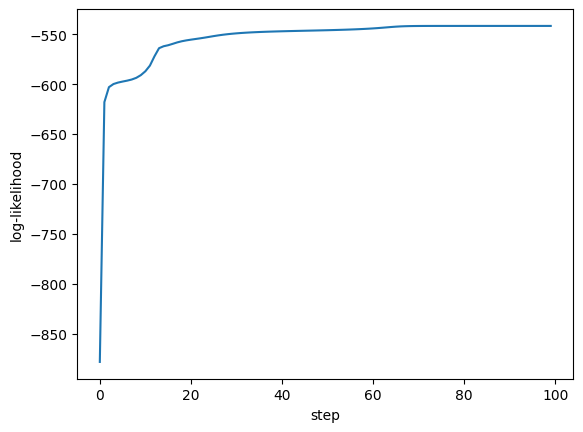

In [11]:
def run_EM(X_samples_array, z_array, n_steps = 100):
    # X_samples_array of shape (N_samples, dim)
    # z_array of shape K_clusters

    N_samples, dim = X_samples_array.shape
    K_clusters = len(z_array)

    # we initalise our parameters at random
    alpha_t_array = np.ones(K_clusters) / K_clusters
    indices = np.random.choice(N_samples, K_clusters, replace=False)
    mu_t_array = X_samples_array[indices]
    emp_cov = np.cov(X_samples_array, rowvar=False)
    sigma_t_matrix = np.stack([emp_cov.copy() for _ in range(K_clusters)])
    list_log_likelihood = []


    for i in range(n_steps):
        # E step
        gamma_t_array = compute_gamma(X_samples_array, alpha_t_array, mu_t_array, sigma_t_matrix)

        # We compute and save the log-likelihh
        list_log_likelihood.append(compute_log_likelihood(X_samples_array, alpha_t_array, mu_t_array, sigma_t_matrix))

        # M step
        alpha_t_1_array = compute_alpha(gamma_t_array)
        mu_t_1_array = compute_mu(X_samples_array, gamma_t_array)
        sigma_t_1_matrix = compute_sigma(X_samples_array, mu_t_1_array, gamma_t_array)
        


        alpha_t_array, mu_t_array, sigma_t_matrix = alpha_t_1_array, mu_t_1_array, sigma_t_1_matrix


    return alpha_t_array, mu_t_array, sigma_t_matrix, list_log_likelihood


alpha_t_array, mu_t_array, sigma_t_matrix, list_log_likelihood = run_EM(X_samples_array, z_array, n_steps = 100)


plt.figure()
plt.plot(range(len(list_log_likelihood)), list_log_likelihood)
plt.xlabel("step")
plt.ylabel("log-likelihood")

**observation:** Our log-likelihood increases sharply in the early steps, meaning there is a significant improvement in the estimated paramters. However, beyond 20 steps, the log-likelihood reaches an upper limit and no further improvments result from the computation

### Question 4

In [ ]:
raise RuntimeError("DO NOT RERUN OR YOU WILL HAVE TO REDEFINE THE REINDEXES")

In [ ]:
# we re-order because there is no reason for the clusters to be in the right order
index_order = np.array([1, 0, 2])
alpha_t_array = alpha_t_array[index_order]
mu_t_array = mu_t_array[index_order]
sigma_t_matrix = sigma_t_matrix[index_order]

In [ ]:
print(f"distance on alpha: {np.linalg.norm(alpha_t_array - alpha_array)}") 
print(f"distance on mu: {np.linalg.norm(mu_t_array - mu_array)}")
print(f"distance on sigma: {np.linalg.norm(sigma_t_matrix - sigma_matrix)}\n")


print("Estimated alphas:\n", alpha_t_array)
print("\nOriginal alphas:\n", alpha_array) 
print("\nEstimated mu:\n", mu_t_array)
print("\nOriginal mu:\n", mu_array)
print("\nEstimated sigma:\n", sigma_t_matrix)
print("\nOriginal sigmas:\n", sigma_matrix)


distance on alpha: 0.10027830735407033
distance on mu: 0.13346052307798875
distance on sigma: 0.21679550321323907

Estimated alphas:
 [0.37999986 0.17509595 0.44490418]

Original alphas:
 [0.3 0.2 0.5]

Estimated mu:
 [[-2.06964811 -0.00631141]
 [ 3.07692623  1.06776131]
 [ 2.04566573 -0.98193291]]

Original mu:
 [[-2  0]
 [ 3  1]
 [ 2 -1]]

Estimated sigma:
 [[[ 0.19380421  0.00959796]
  [ 0.00959796  0.0706278 ]]

 [[ 0.3724958   0.13696248]
  [ 0.13696248  0.29717035]]

 [[ 0.45689107 -0.24488142]
  [-0.24488142  0.62754895]]]

Original sigmas:
 [[[ 0.2  0. ]
  [ 0.   0.1]]

 [[ 0.5  0.2]
  [ 0.2  0.4]]

 [[ 0.5 -0.2]
  [-0.2  0.7]]]


**observation:** Overall, as the linalg norm shows, performance is good and we find parameters similar to the real ones. It is on the alpha where, when comparing the index values between the estimated and the real value, we notice there is the highest difference.

### Question 5

In [13]:
import_data_pd = pd.read_csv(r"C:\Users\titou\Desktop\cours_MVA\MVA_code\computational_statistics\WPP2024_Demographic_Indicators_Medium.csv")
import_data_pd[["CBR", "CDR"]].describe()

C:\Users\titou\AppData\Local\Temp\ipykernel_18100\110787845.py:1: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  import_data_pd = pd.read_csv(r"C:\Users\titou\Desktop\cours_MVA\MVA_code\computational_statistics\WPP2024_Demographic_Indicators_Medium.csv")


,CBR,CDR
count,83805.000000,83805.000000
mean,20.855080,10.927942
std,12.855018,4.701542
min,2.467000,0.841000
25%,10.341000,7.670000
50%,16.132000,9.984000
75%,29.125000,12.932000
max,58.627000,153.963000


<Axes: title={'center': 'scatter plot of CBR vs CDR'}, xlabel='CBR', ylabel='CDR'>

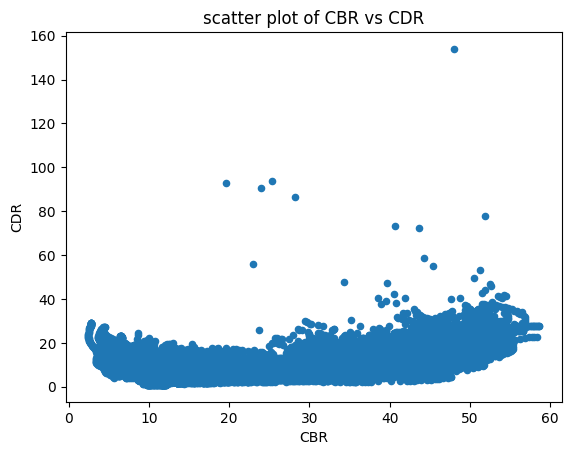

In [14]:
import_data_pd.plot(kind="scatter", x="CBR", y="CDR", title="scatter plot of CBR vs CDR")

**Observation**: The scatter plots show that this is a case in which clustering is not the intuitive approach: there seems to be no separation of the data. However, if we want to do clustering, then using a GMM seems like the best choice. There are no ‘clear-cut’ boundaries in this data, so a deterministic approach like K-means or HAC is unlikely to provide good results. GMM is able to model uncertainty, so it seems like the best approach for clustering.

### Question 6

In [15]:
def plot_gmm_contour(X, mu, sigma, grid_size=200):
    X = np.asarray(X)
    mu = np.asarray(mu)
    sigma = np.asarray(sigma)
    K = mu.shape[0]

    print(f"\nDetected {K} mixture components\n")

    # Scatter
    plt.figure(figsize=(6,6))
    plt.scatter(X[:,0], X[:,1], s=5, alpha=0.25)

    # Grid for contour plotting
    x_min, x_max = X[:,0].min(), X[:,0].max()
    y_min, y_max = X[:,1].min(), X[:,1].max()
    x = np.linspace(x_min, x_max, grid_size)
    y = np.linspace(y_min, y_max, grid_size)
    Xg, Yg = np.meshgrid(x, y)
    grid_points = np.column_stack((Xg.ravel(), Yg.ravel()))

    colours= ["red", "green","black","yellow", "orange"]


    # Loop over components
    for k in range(K):
        # print(f"Component {k} ")
        # print(f"Mean:{mu[k]}")
        # print(f"Covariance:{sigma[k]}\n")

        rv = multivariate_normal(mean=mu[k], cov=sigma[k])
        Z = rv.pdf(grid_points).reshape(Xg.shape)

        # plot contour
        plt.contour(Xg, Yg, Z, levels=4,colors=colours[k], linewidths=1.5)
        # plot mean
        plt.scatter(mu[k,0], mu[k,1], marker="x", s=100, c=colours[k], linewidths=2)

    plt.xlabel("CBR")
    plt.ylabel("CDR")
    plt.title(f"GMM contours (K={K})")
    plt.show()

In [16]:
X_samples_array = import_data_pd[["CBR", "CDR"]].dropna().values
z_array = np.array([0, 1, 2])


Detected 3 mixture components



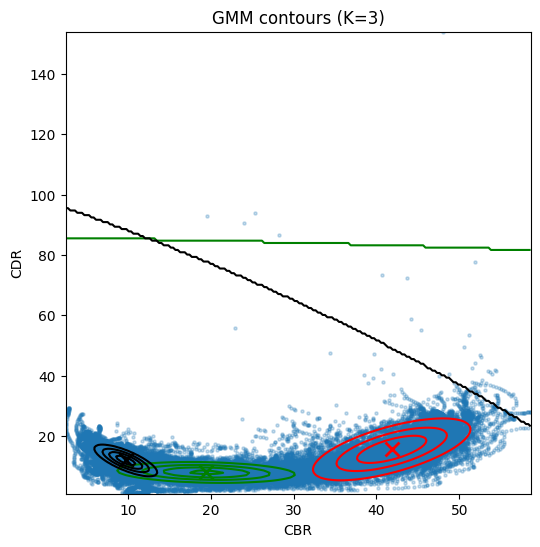

In [18]:
alpha_t_array, mu_t_array, sigma_t_matrix, _ = run_EM(X_samples_array, z_array, n_steps = 100)
plot_gmm_contour(X_samples_array, mu_t_array, sigma_t_matrix)

**Observation**: 

The black cluster (left) are areas with with slightley high mortailty but low nativety. Places like Korea or Japan with an aged population.

The green cluster (middle) are areas with a low mortality rate and a standard birth rate (France, Spain).

The red (right) cluster are areas with high mortality but very high nativety rates.

### Q7

m = 2
  log-likelihood = -519578.52254050697
  df             = 11
  BIC            = 519640.87190423504


Detected 2 mixture components



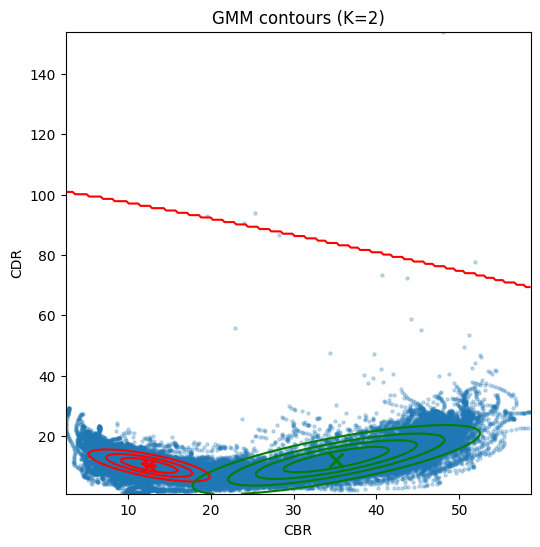

m = 3
  log-likelihood = -503934.96246477356
  df             = 17
  BIC            = 504031.3205723533


Detected 3 mixture components



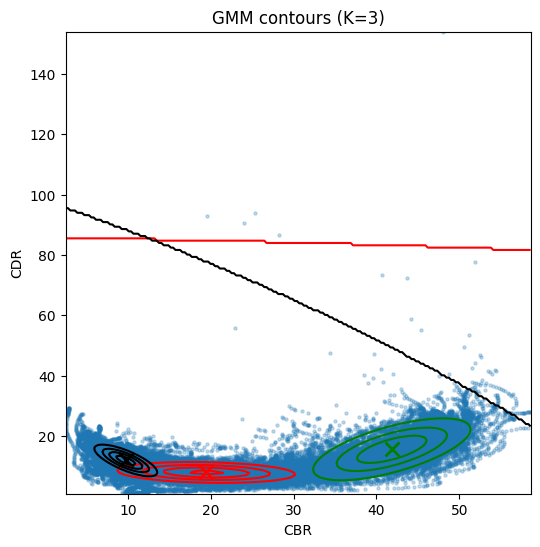

m = 4
  log-likelihood = -501350.98089568166
  df             = 23
  BIC            = 501481.3477471131


Detected 4 mixture components



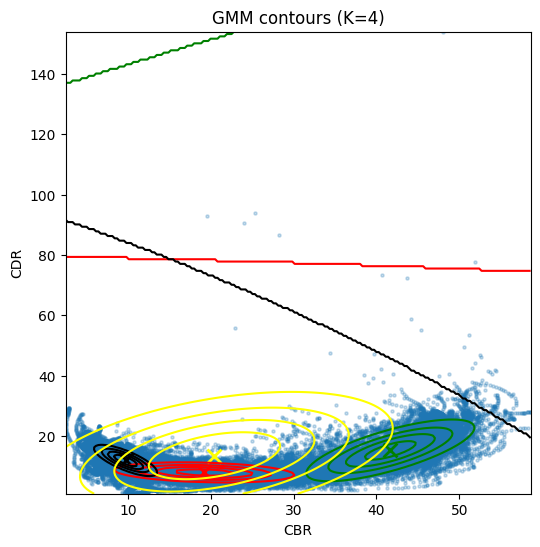

m = 5
  log-likelihood = -497936.50533203606
  df             = 29
  BIC            = 498100.8809273192


Detected 5 mixture components



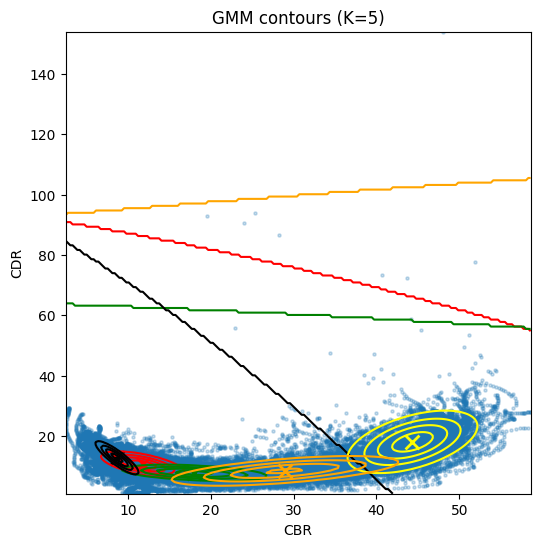

Best m according to BIC: 5


In [19]:
def df_mixture_gaussian(m, d):
    return (m - 1) + m * d + m * d * (d + 1) // 2

def bic_from_loglik(loglik, df, n):
    return -loglik + 0.5 * df * np.log(n)

m_values = [2,3, 4, 5]
bic_scores = {}

for m in m_values:
    z_array = np.arange(m)
    alpha_t_array, mu_t_array, sigma_t_matrix, list_log_likelihood = run_EM(
        X_samples_array, z_array, n_steps=100
    )

    loglik = list_log_likelihood[-1]
    n, d = X_samples_array.shape
    df = df_mixture_gaussian(m, d)
    bic = bic_from_loglik(loglik, df, n)
    bic_scores[m] = bic

    print(f"m = {m}")
    print(f"  log-likelihood = {loglik}")
    print(f"  df             = {df}")
    print(f"  BIC            = {bic}\n")

    plot_gmm_contour(X_samples_array, mu_t_array, sigma_t_matrix)

best_m = min(bic_scores, key=bic_scores.get)
print("Best m according to BIC:", best_m)

**observation**: The best BIC score was for m=5 clusters. Despite M increasing the degrees of freedom, the drop in log-likelihood is substantial enough that ultimelty higher m-values lead to better performance. However, just because m=5 has a lower BIC value does not mean we should use it. Indeed, the clusters we obtain with m=5 are less interpretable that the ones we obtain when m=3, without a significant variation in BIC. If our goal is to interpret our data (as often is the case with clustering), the m=3 choice is still very relevant. 

# Exercise 3.A

### Question 1

In [20]:
# We define the base funcitons:
def p(x):
   return np.where(x >= 0, (x ** 0.65) * np.exp(-x**2 / 2), 0)

def q(x):
    return (2 / np.sqrt(3*np.pi)) * np.exp(-(0.8 - x)**2 /3)

def f(x):
    return np.where(x >= 0, 2 * np.sin((np.pi * x) / 1.5) , 0)

# X = np.arange(-2,3,1)
# print(p(X))
# print(q(X))
# print(f(X))

# Parameter definition:
N_samples = int(1e5)
mu = 0.8
sigma = np.sqrt(1.5)

# defining and running the function:

def importance_sampling(mu, sigma, p, q, f, N_samples):
    # Sampling 
    X = np.random.normal(mu, sigma, N_samples)

    # Compute p, q, g and the normalised weights
    X_p = p(X)
    X_q = q(X)
    X_f = f(X)
    w_array = X_p / X_q
    w_array = w_array / w_array.sum(axis=0) # Note: we do not multiply/divide by the number of samples neither here or when estimating the expected value (since they cancel out)

    return np.sum(w_array * X_f)

importance_sampling(mu, sigma, p, q, f, N_samples)

C:\Users\titou\AppData\Local\Temp\ipykernel_18100\3701030721.py:3: RuntimeWarning: invalid value encountered in power
  return np.where(x >= 0, (x ** 0.65) * np.exp(-x**2 / 2), 0)


np.float64(0.7755026509484773)

The mean we are trying to estimate is of a value around 0.77

### Question 2

In [21]:
for N in [10, 100, 1000, 10000]:
    estimates = []
    for rep in range(int(1e3)):  
        estimates.append( importance_sampling(mu, sigma, p, q, f, N) )
    mean_est = np.mean(estimates)
    var_est  = np.var(estimates, ddof=1)
    print(f"For {N} samples, the mean is {mean_est:.2f} and the variance is {var_est:.2f}")


C:\Users\titou\AppData\Local\Temp\ipykernel_18100\3701030721.py:3: RuntimeWarning: invalid value encountered in power
  return np.where(x >= 0, (x ** 0.65) * np.exp(-x**2 / 2), 0)


For 10 samples, the mean is 0.74 and the variance is 0.23
For 100 samples, the mean is 0.77 and the variance is 0.02
For 1000 samples, the mean is 0.77 and the variance is 0.00
For 10000 samples, the mean is 0.77 and the variance is 0.00


From 1000 samples or more, variance is very low and we are we can say with confidence the expected value of f(X) is 0.77

### Question 3

In [22]:
mu_shifted = 6
def q_shifted(x):
    return (2 / np.sqrt(3*np.pi)) * np.exp(-(6 - x)**2 /3)

for N in [10, 100, 1000, 10000]:
    estimates = []
    for rep in range(int(1e3)):  
        estimates.append( importance_sampling(mu_shifted, sigma, p, q_shifted, f, N) )
    mean_est = np.mean(estimates)
    var_est  = np.var(estimates, ddof=1)
    print(f"For {N} samples, the mean is {mean_est:.2f} and the variance is {var_est:.2f}")


For 10 samples, the mean is 0.35 and the variance is 1.72
For 100 samples, the mean is 0.07 and the variance is 1.59
For 1000 samples, the mean is -1.02 and the variance is 0.64


C:\Users\titou\AppData\Local\Temp\ipykernel_18100\3701030721.py:3: RuntimeWarning: invalid value encountered in power
  return np.where(x >= 0, (x ** 0.65) * np.exp(-x**2 / 2), 0)


For 10000 samples, the mean is -0.08 and the variance is 0.95


C:\Users\titou\AppData\Local\Temp\ipykernel_18100\3701030721.py:3: RuntimeWarning: invalid value encountered in power
  return np.where(x >= 0, (x ** 0.65) * np.exp(-x**2 / 2), 0)


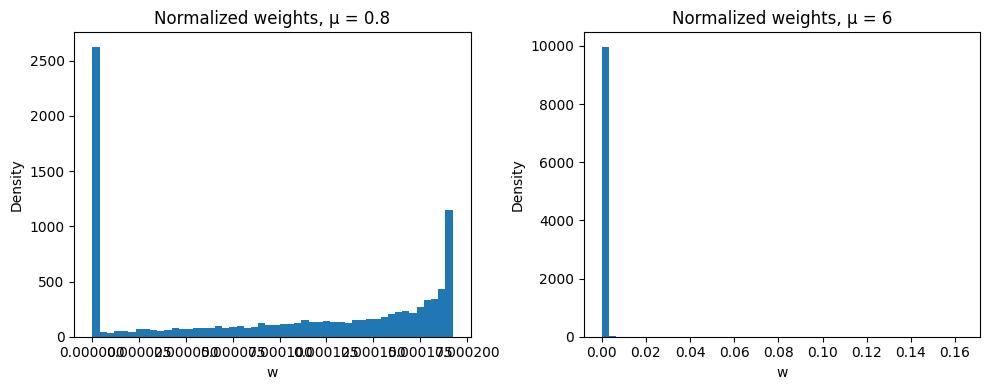

In [23]:

def get_normalized_weights(mu, sigma, p, q_func, N):
    X = np.random.normal(mu, sigma, N)

    # Compute raw weights
    X_p = p(X)
    X_q = q_func(X)
    w_raw = X_p / X_q

    # Normalise
    w_norm = w_raw / w_raw.sum()

    return X, w_norm

N_weights = 10_000  # size for weight comparison

X1, w1 = get_normalized_weights(mu, sigma, p, q, N_weights)
X2, w2 = get_normalized_weights(mu_shifted, sigma, p, q_shifted, N_weights)

# Plot histograms of normalized weights
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(w1, bins=50)
plt.title("Normalized weights, μ = 0.8")
plt.xlabel("w")
plt.ylabel("Density")

plt.subplot(1, 2, 2)
plt.hist(w2, bins=50)
plt.title("Normalized weights, μ = 6")
plt.xlabel("w")
plt.ylabel("Density")

plt.tight_layout()
plt.show()

**observation:** With $\mu=6$, the estimator no longer has a good performance: the variance is much higher. As we can see with when looking at the weights, there is a much more uniform distribution of the weights with $\mu=0.6$ than with $\mu=6$. Indeed, with $\mu=6$, most weights are at 0. This means that the estimator is built on the value of $f$ in a small number of datapoints $X_i$, leading to high variance.